In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
def brier_score(pred_prob, ytrue):
  return np.mean((pred_prob - ytrue)**2)


def brier_score_loss(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    return tf.reduce_mean(tf.math.squared_difference(y_true, y_pred))

In [ ]:
training = False

### Read in the training data for 2003-2022

In [ ]:
# Read in data and clean it up for testing (i.e. use season averages)
DATA_PATH = 'drive/MyDrive/march_madness_2023/march-machine-learning-mania-2023__3-13-23/'

df = pd.read_csv(DATA_PATH + 'Mfinal_data_2003-2022.csv')
to_drop = [col for col in df.columns if '14' in col]
df.drop(to_drop, axis=1, inplace=True)

print(df.shape)
df.head()

(2496, 19)


,Season,TeamIDA,TeamIDB,SeedA,SeedB,OffEffA,DefEffA,EFTA,WinRatioA,GapAvgA,AvgRankA,OffEffB,DefEffB,EFTB,WinRatioB,GapAvgB,AvgRankB,ScoreDiff,WinA
0,2003,1421,1411,16,16,105.315164,115.456256,0.489800,0.448276,-7.241379,259.2,107.187241,105.071425,0.503036,0.600000,1.966667,259.4,8,1
1,2003,1112,1436,1,16,115.232944,95.117513,0.517632,0.892857,14.964286,2.6,106.911164,99.247639,0.494732,0.655172,4.655172,159.6,29,1
2,2003,1113,1272,10,7,113.782349,103.406731,0.517334,0.620690,6.793103,33.6,109.889666,97.004974,0.498337,0.793103,8.689655,21.8,13,1
3,2003,1141,1166,11,6,114.122499,105.421379,0.572835,0.793103,6.103448,43.4,118.566346,96.739284,0.567455,0.878788,14.909091,23.0,6,1
4,2003,1143,1301,8,9,109.611481,102.725168,0.524098,0.724138,4.724138,36.2,111.669631,105.001178,0.534189,0.600000,4.400000,45.0,2,1


In [ ]:
# Set up X and Y
to_drop = ['Season', 'TeamIDA', 'TeamIDB', 'ScoreDiff', 'WinA']
X = df.drop(to_drop, axis=1)
Y = df['WinA']

X.head()

,SeedA,SeedB,OffEffA,DefEffA,EFTA,WinRatioA,GapAvgA,AvgRankA,OffEffB,DefEffB,EFTB,WinRatioB,GapAvgB,AvgRankB
0,16,16,105.315164,115.456256,0.489800,0.448276,-7.241379,259.2,107.187241,105.071425,0.503036,0.600000,1.966667,259.4
1,1,16,115.232944,95.117513,0.517632,0.892857,14.964286,2.6,106.911164,99.247639,0.494732,0.655172,4.655172,159.6
2,10,7,113.782349,103.406731,0.517334,0.620690,6.793103,33.6,109.889666,97.004974,0.498337,0.793103,8.689655,21.8
3,11,6,114.122499,105.421379,0.572835,0.793103,6.103448,43.4,118.566346,96.739284,0.567455,0.878788,14.909091,23.0
4,8,9,109.611481,102.725168,0.524098,0.724138,4.724138,36.2,111.669631,105.001178,0.534189,0.600000,4.400000,45.0


In [ ]:
# Split into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=22)

# Use standard scaler on features
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(X_train_scaled.shape)

(1747, 14)


### Train and save the model

Use a simple architecture with small dense layers

In [ ]:
if training:
  from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
  from tensorflow.keras import Model, Input
  from tensorflow.keras import metrics, regularizers, callbacks

In [ ]:
if training:
  # Simple, small
  inputs = Input(shape=(14,))
  x = Dense(32, activation='relu')(inputs)
  x = BatchNormalization()(x)
  x = Dropout(0.2)(x)
  x = Dense(32, activation='relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.2)(x)
  x = Dense(32, activation='relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.2)(x)
  outputs = Dense(1)(x)

  model = Model(inputs=inputs, outputs=outputs, name='simple_small')
  model.summary()

Model: "simple_small"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 14)]              0         
                                                                 
 dense_8 (Dense)             (None, 32)                480       
                                                                 
 batch_normalization_6 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 32)                1056      
                                                                 
 batch_normalization_7 (Batc  (None, 32)               128       
 hNormalization)                                      

In [ ]:
if training:
  model.compile(optimizer='adam',
                loss=brier_score_loss,
                metrics=[metrics.BinaryCrossentropy()
                ])
  history = model.fit(X_train_scaled, Y_train,
                      batch_size=32, epochs=300,
                      validation_data=(X_test_scaled, Y_test),
                      callbacks=callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=50),
                      verbose=1)

Epoch 1/300
55/55 [==============================] - 3s 9ms/step - loss: 1.2621 - binary_crossentropy: 4.7822 - val_loss: 0.3100 - val_binary_crossentropy: 0.9658
Epoch 2/300
55/55 [==============================] - 0s 5ms/step - loss: 0.8103 - binary_crossentropy: 3.9217 - val_loss: 0.2589 - val_binary_crossentropy: 0.7412
Epoch 3/300
55/55 [==============================] - 0s 5ms/step - loss: 0.6107 - binary_crossentropy: 3.2370 - val_loss: 0.2523 - val_binary_crossentropy: 0.7533
Epoch 4/300
55/55 [==============================] - 0s 4ms/step - loss: 0.5391 - binary_crossentropy: 2.8717 - val_loss: 0.2456 - val_binary_crossentropy: 0.7230
Epoch 5/300
55/55 [==============================] - 0s 5ms/step - loss: 0.4417 - binary_crossentropy: 2.5021 - val_loss: 0.2414 - val_binary_crossentropy: 0.6964
Epoch 6/300
55/55 [==============================] - 0s 5ms/step - loss: 0.4236 - binary_crossentropy: 2.4231 - val_loss: 0.2329 - val_binary_crossentropy: 0.6761
Epoch 7/300
55/55 [===

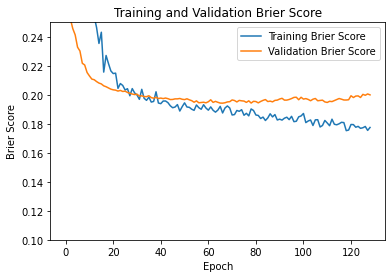

In [ ]:
if training:
  plt.plot(history.history['loss'], label='Training Brier Score')
  plt.plot(history.history['val_loss'], label='Validation Brier Score')
  plt.title('Training and Validation Brier Score')
  plt.xlabel('Epoch')
  plt.ylabel('Brier Score')
  plt.ylim(0.1,0.25)
  plt.legend()
  plt.show()

In [ ]:
if training:
  # Save the entire model as a SavedModel.
  !mkdir -p saved_model
  model.save('saved_model/Mfinal_model')
else:
  model = keras.model.load_model('saved_model/Mfinal_model')

### Predict on 2023 data and create men's bracket

In [ ]:
df_2023 = pd.read_csv(DATA_PATH + 'Mtesting_features_2023.csv')
df_2023.head()

,Season,TeamID,Seed,OffEff,DefEff,EFT,WinRatio,GapAvg,AvgRank
0,2023,1101,17.0,104.054373,109.176644,0.496123,0.346154,-3.692308,209.4
1,2023,1102,17.0,109.027211,109.472507,0.543690,0.437500,-0.125000,159.0
2,2023,1103,17.0,111.839886,103.062605,0.520276,0.645161,5.838710,106.6
3,2023,1104,1.0,113.886744,94.430541,0.528760,0.852941,13.676471,1.6
4,2023,1105,17.0,99.898342,103.968525,0.489802,0.400000,-3.066667,319.4


In [ ]:
# Read in Team names
df_teams = pd.read_csv(DATA_PATH + 'MTeams.csv')
df_teams = df_teams[df_teams['FirstD1Season'] < 2023]
df_teams = df_teams.drop(['FirstD1Season', 'LastD1Season'], axis=1)

print(df_teams.shape)
df_teams.head()

(372, 2)


,TeamID,TeamName
0,1101,Abilene Chr
1,1102,Air Force
2,1103,Akron
3,1104,Alabama
4,1105,Alabama A&M


In [ ]:
# Read in Seeds for 2023 bracket
df_seeds = pd.read_csv(DATA_PATH + 'MNCAATourneySeeds.csv')
df_seeds = df_seeds[df_seeds.Season == 2023]

def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))

df_seeds['Seed'] = df_seeds['Seed'].apply(treat_seed)

df_seeds.head()

,Season,Seed,TeamID
2422,2023,1,1345
2423,2023,2,1266
2424,2023,3,1243
2425,2023,4,1397
2426,2023,5,1181


In [ ]:
def get_game_data(teamA, teamB, teams, features):

  if teamA not in teams.TeamName.tolist():
    raise NameError('{} not in team names csv'.format(teamA))
  if teamB not in teams.TeamName.tolist():
    raise NameError('{} not in team names csv'.format(teamB))

  teamA = teams[teams.TeamName == teamA].drop(['TeamName'], axis=1)
  teamB = teams[teams.TeamName == teamB].drop(['TeamName'], axis=1)

  teamA = pd.merge(teamA, features, on='TeamID', how='left')
  teamB = pd.merge(teamB, features, on='TeamID', how='left').drop('Season', axis=1)

  teamA.rename(columns={
      'TeamID' : 'TeamIDA',
      'Seed' : 'SeedA',
      'OffEff' : 'OffEffA',
      'DefEff' : 'DefEffA',
      'EFT' : 'EFTA',
      'WinRatio' : 'WinRatioA',
      'GapAvg' : 'GapAvgA',
      'AvgRank' : 'AvgRankA'
  }, inplace=True)

  teamB.rename(columns={
      'TeamID' : 'TeamIDB',
      'Seed' : 'SeedB',
      'OffEff' : 'OffEffB',
      'DefEff' : 'DefEffB',
      'EFT' : 'EFTB',
      'WinRatio' : 'WinRatioB',
      'GapAvg' : 'GapAvgB',
      'AvgRank' : 'AvgRankB'
  }, inplace=True)

  game = pd.concat([teamA, teamB], axis=1)
  cols = ['Season', 'TeamIDA', 'TeamIDB', 'SeedA', 'SeedB',
          'OffEffA', 'DefEffA', 'EFTA', 'WinRatioA', 'GapAvgA',
          'AvgRankA', 'OffEffB', 'DefEffB', 'EFTB', 'WinRatioB',
          'GapAvgB', 'AvgRankB']
  game = game[cols]

  return game


def get_seeds(team1_name, team2_name, teams, seeds):

    if team1_name not in teams.TeamName.tolist():
      raise NameError('{} not in team names csv'.format(team1_name))
    if team2_name not in teams.TeamName.tolist():
      raise NameError('{} not in team names csv'.format(team2_name))

    teamA = teams[teams.TeamName == team1_name]
    teamB = teams[teams.TeamName == team2_name]

    teamA = pd.merge(teamA, seeds, on='TeamID', how='left')
    teamB = pd.merge(teamB, seeds, on='TeamID', how='left')

    return teamA.Seed.tolist()[0], teamB.Seed.tolist()[0]

In [ ]:
# Input arrays for 2023 bracket
round_of_64 = [
    ['Alabama',        'TAM C. Christi'],
    ['Maryland',       'West Virginia'],
    ['San Diego St',   'Col Charleston'],
    ['Virginia',       'Furman'],
    ['Creighton',      'NC State'],
    ['Baylor',         'UC Santa Barbara'],
    ['Missouri',       'Utah St'],
    ['Arizona',        'Princeton'],
    ['Houston',        'N Kentucky'],
    ['Iowa',           'Auburn'],
    ['Miami FL',       'Drake'],
    ['Indiana',        'Kent'],
    ['Iowa St',        'Pittsburgh'],
    ['Xavier',         'Kennesaw'],
    ['Texas A&M',      'Penn St'],
    ['Texas',          'Colgate'],
    ['Purdue',         'TX Southern'],
    ['Memphis',        'FL Atlantic'],
    ['Duke',           'Oral Roberts'],
    ['Tennessee',      'Louisiana'],
    ['Kentucky',       'Providence'],
    ['Kansas St',      'Montana St'],
    ['Michigan St',    'USC'],
    ['Marquette',      'Vermont'],
    ['Kansas',         'Howard'],
    ['Arkansas',       'Illinois'],
    ["St Mary's CA",   'VCU'],
    ['Connecticut',          'Iona'],
    ['TCU',            'Arizona St'],
    ['Gonzaga',        'Grand Canyon'],
    ['Northwestern',   'Boise St'],
    ['UCLA',         'UNC Asheville']
]

round_of_32 = [
    ['A','B'],
    ['A','B'],
    ['A','B'],
    ['A','B'],
    ['A','B'],
    ['A','B'],
    ['A','B'],
    ['A','B'],
    ['A','B'],
    ['A','B'],
    ['A','B'],
    ['A','B'],
    ['A','B'],
    ['A','B'],
    ['A','B'],
    ['A','B']
]

sweet_16 = [
    ['A','B'],
    ['A','B'],
    ['A','B'],
    ['A','B'],
    ['A','B'],
    ['A','B'],
    ['A','B'],
    ['A','B']
]

elite_8 = [
    ['A','B'],
    ['A','B'],
    ['A','B'],
    ['A','B']
]

final_4 = [
    ['A','B'],
    ['A','B']
]

ship = ['A','B']

In [ ]:
# Predict Round of 64
# Generate Round of 64 games
games_64 = pd.DataFrame()
for g,teams in enumerate(round_of_64):
    games_64 = pd.concat([games_64, get_game_data(teams[0], teams[1], df_teams, df_2023)])

games_64 = games_64.drop(['Season', 'TeamIDA', 'TeamIDB'], axis=1)
game_X = scaler.transform(games_64)
preds = model.predict(game_X, verbose=0)

print('-- Round of 64 --')
i = 0
j = 0
regions = ['South','Midwest','West','East']
for g,teams in enumerate(round_of_64):
    if g % 8 == 0:
        print('\n%s Region:' %(regions[i]))
        i += 1

    s1, s2 = get_seeds(teams[0], teams[1], df_teams, df_seeds)

    if preds[g] >= 0.5:

        if g % 2 == 0:
            round_of_32[j][0] = teams[0]
        elif g % 2 == 1:
            round_of_32[j][1] = teams[0]
            j += 1

        print('%s (%d) beats %s (%d) with probability: %.4f' % (teams[0], s1, teams[1], s2, preds[g]))

    else:

        if g % 2 == 0:
            round_of_32[j][0] = teams[1]
        elif g % 2 == 1:
            round_of_32[j][1] = teams[1]
            j += 1

        print('%s (%d) beats %s (%d) with probability: %.4f' % (teams[1], s2, teams[0], s1, 1-preds[g]))


-- Round of 64 --

South Region:
Alabama (1) beats TAM C. Christi (16) with probability: 0.9814
Maryland (8) beats West Virginia (9) with probability: 0.5378
San Diego St (5) beats Col Charleston (12) with probability: 0.5633
Virginia (4) beats Furman (13) with probability: 0.8314
Creighton (6) beats NC State (11) with probability: 0.5759
Baylor (3) beats UC Santa Barbara (14) with probability: 0.9412
Utah St (10) beats Missouri (7) with probability: 0.6469
Arizona (2) beats Princeton (15) with probability: 0.8686

Midwest Region:
Houston (1) beats N Kentucky (16) with probability: 1.0072
Auburn (9) beats Iowa (8) with probability: 0.6128
Miami FL (5) beats Drake (12) with probability: 0.7272
Indiana (4) beats Kent (13) with probability: 0.7258
Iowa St (6) beats Pittsburgh (11) with probability: 0.6988
Xavier (3) beats Kennesaw (14) with probability: 0.9653
Texas A&M (7) beats Penn St (10) with probability: 0.8010
Texas (2) beats Colgate (15) with probability: 0.9500

West Region:
Purd

In [ ]:
# Predict Round of 32
# Generate Round of 32 games
games_32 = pd.DataFrame()
for g,teams in enumerate(round_of_32):
    games_32 = pd.concat([games_32, get_game_data(teams[0], teams[1], df_teams, df_2023)])

games_32 = games_32.drop(['Season', 'TeamIDA', 'TeamIDB'], axis=1)
game_X = scaler.transform(games_32)
preds = model.predict(game_X, verbose=0)

print('-- Round of 32 --')
i = 0
j = 0
regions = ['South','Midwest','West','East']
for g,teams in enumerate(round_of_32):
    if g % 4 == 0:
        print('\n%s Region:' %(regions[i]))
        i += 1

    s1, s2 = get_seeds(teams[0], teams[1], df_teams, df_seeds)

    if preds[g] >= 0.5:

        if g % 2 == 0:
            sweet_16[j][0] = teams[0]
        elif g % 2 == 1:
            sweet_16[j][1] = teams[0]
            j += 1

        print('%s (%d) beats %s (%d) with probability: %.4f' % (teams[0], s1, teams[1], s2, preds[g]))

    else:

        if g % 2 == 0:
            sweet_16[j][0] = teams[1]
        elif g % 2 == 1:
            sweet_16[j][1] = teams[1]
            j += 1

        print('%s (%d) beats %s (%d) with probability: %.4f' % (teams[1], s2, teams[0], s1, 1-preds[g]))


-- Round of 32 --

South Region:
Alabama (1) beats Maryland (8) with probability: 0.7667
San Diego St (5) beats Virginia (4) with probability: 0.5218
Creighton (6) beats Baylor (3) with probability: 0.5670
Arizona (2) beats Utah St (10) with probability: 0.8864

Midwest Region:
Houston (1) beats Auburn (9) with probability: 0.9503
Indiana (4) beats Miami FL (5) with probability: 0.6266
Iowa St (6) beats Xavier (3) with probability: 0.5832
Texas (2) beats Texas A&M (7) with probability: 0.7470

West Region:
Purdue (1) beats FL Atlantic (9) with probability: 0.6997
Tennessee (4) beats Duke (5) with probability: 0.5379
Kansas St (3) beats Kentucky (6) with probability: 0.5741
Marquette (2) beats Michigan St (7) with probability: 0.7132

East Region:
Illinois (9) beats Kansas (1) with probability: 0.5148
Connecticut (4) beats St Mary's CA (5) with probability: 0.5537
Gonzaga (3) beats TCU (6) with probability: 0.7155
UCLA (2) beats Northwestern (7) with probability: 0.7324


In [ ]:
# Predict Sweet 16
# Generate Sweet 16 games
games_16 = pd.DataFrame()
for g,teams in enumerate(sweet_16):
    games_16 = pd.concat([games_16, get_game_data(teams[0], teams[1], df_teams, df_2023)])

games_16 = games_16.drop(['Season', 'TeamIDA', 'TeamIDB'], axis=1)
game_X = scaler.transform(games_16)
preds = model.predict(game_X, verbose=0)

print('-- Sweet 16 --')
i = 0
j = 0
regions = ['South','Midwest','West','East']
for g,teams in enumerate(sweet_16):
    if g % 2 == 0:
        print('\n%s Region:' %(regions[i]))
        i += 1

    s1, s2 = get_seeds(teams[0], teams[1], df_teams, df_seeds)

    if preds[g] >= 0.5:

        if g % 2 == 0:
            elite_8[j][0] = teams[0]
        elif g % 2 == 1:
            elite_8[j][1] = teams[0]
            j += 1

        print('%s (%d) beats %s (%d) with probability: %.4f' % (teams[0], s1, teams[1], s2, preds[g]))

    else:

        if g % 2 == 0:
            elite_8[j][0] = teams[1]
        elif g % 2 == 1:
            elite_8[j][1] = teams[1]
            j += 1

        print('%s (%d) beats %s (%d) with probability: %.4f' % (teams[1], s2, teams[0], s1, 1-preds[g]))


-- Sweet 16 --

South Region:
Alabama (1) beats San Diego St (5) with probability: 0.6675
Arizona (2) beats Creighton (6) with probability: 0.8379

Midwest Region:
Houston (1) beats Indiana (4) with probability: 0.8507
Texas (2) beats Iowa St (6) with probability: 0.7539

West Region:
Purdue (1) beats Tennessee (4) with probability: 0.5844
Marquette (2) beats Kansas St (3) with probability: 0.6438

East Region:
Connecticut (4) beats Illinois (9) with probability: 0.8540
UCLA (2) beats Gonzaga (3) with probability: 0.5352


In [ ]:
# Predict Elite 8 games
# Generate Elite 8 games
games_8 = pd.DataFrame()
for g,teams in enumerate(elite_8):
    games_8 = pd.concat([games_8, get_game_data(teams[0], teams[1], df_teams, df_2023)])

games_8 = games_8.drop(['Season', 'TeamIDA', 'TeamIDB'], axis=1)
game_X = scaler.transform(games_8)
preds = model.predict(game_X, verbose=0)

print('-- Elite 8 --')
i = 0
j = 0
regions = ['South','Midwest','West','East']
for g,teams in enumerate(elite_8):
    if g % 1 == 0:
        print('\n%s Region:' %(regions[i]))
        i += 1

    s1, s2 = get_seeds(teams[0], teams[1], df_teams, df_seeds)

    if preds[g] >= 0.5:

        if g % 2 == 0:
            final_4[j][0] = teams[0]
        elif g % 2 == 1:
            final_4[j][1] = teams[0]
            j += 1

        print('%s (%d) beats %s (%d) with probability: %.4f' % (teams[0], s1, teams[1], s2, preds[g]))

    else:

        if g % 2 == 0:
            final_4[j][0] = teams[1]
        elif g % 2 == 1:
            final_4[j][1] = teams[1]
            j += 1

        print('%s (%d) beats %s (%d) with probability: %.4f' % (teams[1], s2, teams[0], s1, 1-preds[g]))


-- Elite 8 --

South Region:
Arizona (2) beats Alabama (1) with probability: 0.5093

Midwest Region:
Houston (1) beats Texas (2) with probability: 0.5687

West Region:
Purdue (1) beats Marquette (2) with probability: 0.6085

East Region:
UCLA (2) beats Connecticut (4) with probability: 0.5689


In [ ]:
# Something went wrong and switched the matchups
final_4 = [
    ['Arizona','Purdue'],
    ['Houston','UCLA']
]

In [ ]:
# Predict Final Four
# Generate Final Four games
games_4 = pd.DataFrame()
for g,teams in enumerate(final_4):
    games_4 = pd.concat([games_4, get_game_data(teams[0], teams[1], df_teams, df_2023)])

games_4 = games_4.drop(['Season', 'TeamIDA', 'TeamIDB'], axis=1)
game_X = scaler.transform(games_4)
preds = model.predict(game_X, verbose=0)

print('-- Final Four --')
i = 0
regions = ['South','Midwest','West','East']
for g,teams in enumerate(final_4):

    s1, s2 = get_seeds(teams[0], teams[1], df_teams, df_seeds)

    if preds[g] >= 0.5:

        ship[i] = teams[0]
        print('%s (%d) beats %s (%d) with probability: %.4f' % (teams[0], s1, teams[1], s2, preds[g]))

    else:

        ship[i] = teams[1]
        print('%s (%d) beats %s (%d) with probability: %.4f' % (teams[1], s2, teams[0], s1, 1-preds[g]))

    i += 1


-- Final Four --
Purdue (1) beats Arizona (2) with probability: 0.5724
Houston (1) beats UCLA (2) with probability: 0.5420


In [ ]:
# Predict Championship
# Generate Championship game
champ = get_game_data(ship[0], ship[1], df_teams, df_2023)

champ = champ.drop(['Season', 'TeamIDA', 'TeamIDB'], axis=1)
game_X = scaler.transform(champ)
preds = model.predict(game_X, verbose=0)

teams = ship
s1, s2 = get_seeds(teams[0], teams[1], df_teams, df_seeds)

if preds >= 0.5:
    print('%s (%d) beats %s (%d) with probability: %.4f' % (teams[0], s1, teams[1], s2, preds))

else:
    print('%s (%d) beats %s (%d) with probability: %.4f' % (teams[1], s2, teams[0], s1, 1-preds))


Houston (1) beats Purdue (1) with probability: 0.6672


In [ ]:
# Predict the championship score
# Average winning championship score from 2003 - 2022
# Average losing championship score from 2003 - 2022
t = pd.read_csv(DATA_PATH + 'MNCAATourneyDetailedResults.csv')
t = t[t.Season < 2023]
t = t[t.DayNum == 154] # only look at championships
print('Average winning score: {:.4f}'.format(t.WScore.mean()))
print('Average losing score: {:.4f}'.format(t.LScore.mean()))
print('Total average score: {:.4f}'.format(t.WScore.mean() + t.LScore.mean()))

Average winning score: 74.7368
Average losing score: 66.4211
Total average score: 141.1579


### Create submission file for Kaggle

In [ ]:
# df_sub = pd.read_csv(DATA_PATH + 'SampleSubmission2023.csv')

# def split_ID():
# df_sub